<hr style="border:2px solid coral"></hr>

## Conjugate Gradient Algorithm

<hr style="border:2px solid coral"></hr>

#### Conjugate gradient algorithm

    xk = x0
    rk = b - A*xk
    pk = rk
    for k = 0,1,2
        Compute Apk = A*pk                # Matrix-vector product
        alpha_k = rk.T*rk/(rk.T*Apk)
        xkp1 = xk + alpha_k*pk       # New solution iterate
        rkp1 = rk - alpha_k*Apk      # New residual
        
        beta = rkp1.T*rpk1/rk.T*rk
        pkp1 = rkp1 + beta*pk        # new "A-conjugate" search direction
        
        if norm(rkp1) < tau          # Stopping criteria
            stop

        # Update xk,rk,pk

In [1]:
from numpy import *
from matplotlib.pyplot import *

from numpy.linalg import solve, norm


In [2]:
# Conjugate gradient algorithm

from numpy.linalg import solve, norm

def cg(A,F,kmax=10000,tol=1e-12,prt=False):
    xk = zeros(F.shape)
    rk = F - A@xk
    pk = rk
    for k in range(kmax):
        itcount = k
        
        Apk = A@pk    
        pAp = pk.T@Apk
        if pAp == 0:
            print("pAp == 0")
            xkp1 = xk
            break
        rTr = rk.T@rk
        alpha = rTr/pAp
        xkp1 = xk + alpha*pk
        rkp1 = rk - alpha*Apk
        
        # Steepest descent directions   : pkp1 = rkp1

        # A-conjugate search directions : pkp1 = rkp1 + beta*pk
        beta = rkp1.T@rkp1/rTr    
        pkp1 = rkp1 + beta*pk
        
        err = norm(rkp1,inf)
        if prt:
            print(f"{k:5d} {err:12.4e}")
            
        if err < tol:
            break
        pk = pkp1
        rk = rkp1
        xk = xkp1
        
    xk = xkp1
    return xk,itcount        

# Construct (N+1)x(N+1) linear system. 

In [53]:
# Get [1,-2,1] linear system

def get_linsys(N,a,b,upp):
    A = diag(ones(N-2),-1) + -2*diag(ones(N-1)) + diag(ones(N-2),1)
    h = (b-a)/N
    x = linspace(a,b,N+1)[1:-1].reshape((N+1,1))
    F = h**2*upp(x)
    return A, F

### Example

<hr style="border:2px solid black"></hr>

In [54]:
a = 0
b = pi

def u_true(x):
    return x*(x-1)/2
    #return sin(x)

def upp_true(x):
    return ones(x.shape)
    #return -sin(x)

N = 8
A,F = get_linsys(N,a,b,upp_true)

x_cg, itcount = cg(A,F,prt=False)
print(f"Itcount = {itcount}")

ValueError: cannot reshape array of size 7 into shape (9,1)

#### Verify solution

Compare solution using CG to solution using Gaussian Elimination

In [48]:
xtrue = solve(A,F)  # Use Gaussian Elimination
err = norm(xtrue - x_cg,inf)
print(f"Error in linear system  : {err:12.4e}")

Error in linear system  :   2.1760e+01


#### Verify residual

In [49]:
res = norm(F - A@x_cg,inf)
print(f"Residual  : {res:12.4e}")

Residual  :   2.8294e+01


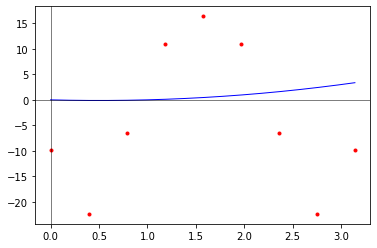

In [50]:
figure(1)
clf()

x = linspace(0,b,N+1)

plot(x,x_cg,'ro',ms=3,label='Computed solution');

xf = linspace(a,b,128)
plot(xf,u_true(xf),'b-',lw=1,label='True solution');

kwargs = {'color' : 'k', 'lw' : 0.5, 'ls' : '-'}
axhline(**kwargs)
axvline(**kwargs);

# legend(loc=4);

### Implementation in C (serial)

<hr style="border:2px solid black"></hr>

In [21]:
%%file cg_serial.c

#include <stdio.h>
#include <stdlib.h>

#include <math.h>

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return mem+m;
}

void free_1d(double **x, int m)
{
    free(*x-m);
    *x = NULL;
}

double utrue(double x)
{
    return x*(x-1)/2;
    //return sin(x);    
}

double rhs(double x)
{
    return 1;
    //return -sin(x);
}

void matvec(int N, double *u, double *L)
{
    for(int i = 0; i < N+1; i++)
        L[i] = (u[i-1] - 2*u[i] + u[i+1]); 
}

int cg(int N, double *F, double *u, double tol, int kmax, int prt)
{
    double *uk = allocate_1d(N+1,1);
    double *pk = allocate_1d(N+1,1);
    
    double rk[N+1];
    for(int i = 0; i < N+1; i++)
    {
        uk[i] = 0;
        rk[i] = F[i];
        pk[i] = rk[i];    // # Start with uk = 0 --> r = b - Au = b
    }
                
    double Apk[N+1];
    double rkp1[N+1];
    
    int itcount = 0;
    for(int k = 0; k < kmax; k++)
    {
        matvec(N,pk,Apk);
        
        // # Compute the residual
        double rTr = 0;
        double pTAp = 0;
        for(int i = 0; i < N+1; i++)
        {
            rTr += rk[i]*rk[i];
            pTAp += pk[i]*Apk[i];
        }
        double alpha = rTr/pTAp;
        
        double rpTrp = 0;
        for(int i = 0; i < N+1; i++)
        {
            uk[i] = uk[i] + alpha*pk[i];
            rkp1[i] = rk[i] - alpha*Apk[i];
            rpTrp += rkp1[i]*rkp1[i];
        }
        
        double beta = rpTrp/rTr;
        
        // update search direction
        for(int i = 0; i < N+1; i++)
            pk[i] = rkp1[i] + beta*pk[i];
        
        if (prt)
            printf("%5d %12.4e\n",k,rpTrp);
        
        itcount = k;
        if (rpTrp < tol)
            break;
        
        // # Update values
        for(int i = 0; i < N+1; i++)
            rk[i] = rkp1[i];
        
        rTr = rpTrp;
            
    }
    for(int i = 0; i < N+1; i++)
        u[i] = uk[i];    
    
    return itcount;
}

int main(int argc, char** argv)
{

    int N;
    if (argc < 2)
        N = 64;
    else
        N = atoi(argv[1]);
    
    
    // # Physical parameters
    double a = 0; 
    double b = 1;
    
    // # Numerial parameters
    double tol = 1e-12;
    int kmax = 100000;
    int prt = 0;
    double h = (b-a)/N;
    
    // # Arrays
    double *u = allocate_1d(N+1,1);
    double F[N+1];
    double Lu[N+1];
    
    // # Initialization
    for(int i = 0; i < N+1; i++)
    {
        double x =  a + i*h;
        F[i] = h*h*rhs(x);        
        u[i] = 0;
    }
    
    // # Compute the solution using Jacobi method
    int itcount = cg(N,F,u,tol,kmax,prt);
        
    
    /* Supply correct ghost cells values */
    matvec(N,u,Lu);
    
    // # Compute error and residual
    double max_res = 0;
    
    for(int i = 0; i < N+1; i++)
    {
        double x = a + h*i;
        
        double res = fabs(F[i] - Lu[i]);
        max_res = fmax(res,max_res);            
        
#if 0
        if (N < 32)
            printf("%5d %16.8f %12.4e %12.4e\n",i, u[i],err,res);
#endif        
    }
    
    printf("\n");
    printf("N = %d\n",N);
    printf("Iteration count     : %24d\n",itcount);
    printf("Residual (inf-norm) : %24.4e\n",max_res/2);
    
    FILE *fout = fopen("cg.dat","wb");   
    fwrite(&N,sizeof(int),1,fout);
    fwrite(&a,sizeof(double),1,fout);
    fwrite(&b,sizeof(double),1,fout);
    fwrite(&u[0],sizeof(double),N+1, fout); 
    fclose(fout);
            
    return 0;
}    

Writing cg_serial.c


### Run code and get output (serial)


In [22]:
%%bash

rm -rf cg_serial.o cg_serial

gcc -o cg_serial cg_serial.c

./cg_serial 64


N = 64
Iteration count     :                       32
Residual (inf-norm) :               0.0000e+00


In [23]:
dt = np.dtype([('N',np.int32),\
               ('a',np.float64), \
               ('b',np.float64),\
               ('u',(np.float64,N+1))])

fout = open("cg.dat","rb")
N,a,b,u = np.fromfile(fout,dtype=dt, count=1)[0]
fout.close()

### Plot the solution (serial)

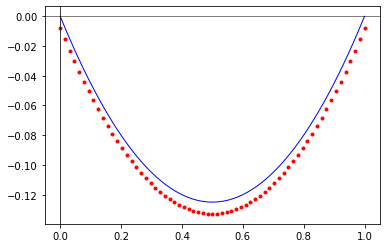

In [24]:
figure(2)
clf()

xf = linspace(a,b,128)
plot(xf,u_true(xf),'b-',lw=1,label='True solution');

x = linspace(a,b,N+1);
plot(x,u,'ro',ms=3,label='Computed solution');

kwargs = {'color' : 'k', 'lw' : 0.5, 'ls' : '-'}
axhline(**kwargs)
axvline(**kwargs)
axvline(**kwargs);

## Verify solution to the PDE

<hr style="border:2px solid black"></hr>

We are hoping to solve $u''(x) = 1$.  Do we? 

In [25]:
assert 1==0, "Don't run past here"

AssertionError: Don't run past here

In [41]:
# Error in solution to PDE
N = 64
A,F = get_linsys(N,a,b,upp_true)

prt = False
if N < 32:
    prt = True
    
x_cg, itcount = cg(A,F,prt=prt)
x = linspace(a,b,N+1).reshape((N+1,1))

print("")
print(f"Iteration count : {itcount:d}")
print("")

utrue = u_true(x)
err_pde = norm(x_cg - utrue,inf)
print(f"Error in PDE  : {err_pde:12.4e}")


Iteration count : 32

Error in PDE  :   4.9278e-02


In [43]:
e =array([4.0059e-01,1.9894e-01,9.8899e-02,4.9278e-02])
with printoptions(formatter={'float' : "{:.4f}".format}):
    print(log2(e[:-1]/e[1:]))

[1.0098 1.0083 1.0050]


In [40]:
e

array([0.40059 , 0.19894 , 0.098899])